# M3 – Week 1

### Towards an image classification pipeline

This work was made by Edward Hogea, Alex Carrillo and Guillem Martínez


On these notebook, we adress the objective of generating an image classification pipeline employing a Bag Of Visual Words (BOVW) algorithm. 

### Imports

In [1]:
import os
import cv2
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from tqdm import tqdm
from joblib import Parallel, delayed, cpu_count
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from typing import List, Dict, Tuple, Any
from copy import deepcopy
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model._base import BaseEstimator
from copy import deepcopy
import pandas as pd
from pylab import rcParams
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data Handling Functions

In [2]:
def preprocess_paths(filepaths: List[str]):
    """
    Removes the "../" (first three characters) using a list comprehension
    """
    return [fpath[3:] for fpath in filepaths]


def load_image(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load image at path.
    """
    return cv2.imread(path)


def load_images(files: List[str], desc: str, n_process: int = cpu_count()) -> Tuple[np.ndarray]:
    """
    Load a list of images by their full filenames.
    """
    images = Parallel(n_jobs=n_process, prefer="threads")(
        delayed(load_image)(file) for file in tqdm(files, desc=desc))
    print(f"read: {len(images)} images")
    return images


def show_image(image: np.ndarray, title: str = 'image'):
    """Shows image."""
    plt.imshow(image[...,::-1])
    plt.title(title)
    plt.show()

### Visualization functions

In [34]:
def plot_params_comparison(df: np.ndarray, detectors: List[str], xvar: str, yvar: str, zvar: str, figsize=(5, 3)):
    fig, ax = plt.subplots(1, len(detectors), figsize=figsize, sharey=True)
    lvls = df[zvar].unique()
    for detector in detectors:
        data = df.copy()[df['detector'] == detector]
        for i in lvls:
            ax[detectors.index(detector)].errorbar(x=data[data[zvar]==i][xvar],
                                                  y=data[data[zvar]==i][yvar], 
                                                  yerr=data[data[zvar]==i][f'std_{yvar}'], label=i, marker='o')
        ax[detectors.index(detector)].set_xlabel(xvar)
        ax[detectors.index(detector)].title.set_text(detector)
        ax[detectors.index(detector)].grid()
    ax[0].set_ylabel(yvar)
    ax[detectors.index(detector)].legend(title=zvar)
    plt.show()

### Feature extractors and other major functionalities

In [4]:
def create_dense_kp(img_shape, step_size):
    return [cv2.KeyPoint(x, y, step_size) for y in range(0, img_shape[0], step_size) 
                                          for x in range(0, img_shape[1], step_size)]


def get_detector(name: str = 'sift', n_features: int = 100) -> Any:
    if name == 'kaze':
        detector = cv2.KAZE_create()
    elif name == 'akaze':
        detector = cv2.AKAZE_create(descriptor_size=n_features)
    elif name == 'brisk':
        detector = cv2.BRISK_create()
    elif name == 'sift':
        detector = cv2.SIFT_create(nfeatures=n_features)
    elif name == 'dense_sift':
        detector = cv2.SIFT_create(nfeatures=n_features)
    else:
        raise ValueError(
            f"Given detector {name} is an invalid one."
        )
    return name, detector

In [5]:
def compute_image_descriptors(image: np.ndarray, detector_name: str, detector: Any, step_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute descriptors for an image using a feature detector.
    """
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    if detector_name == 'dense_sift':
        keypoints = create_dense_kp(gray.shape, step_size=step_size)
        _, descriptors = detector.compute(gray, keypoints)
    else:
        keypoints, descriptors = detector.detectAndCompute(gray, None)
    return keypoints, descriptors

def compute_descriptors(
    images: List[np.ndarray],
    labels: Tuple,
    detector: str,
    n_features: int,
    desc: str,
    step_size: int = 10,
    n_process: int = cpu_count(),
    verbose: bool = False,
    testing: bool = False):
    """
    Compute descriptors for an image using a feature detector.
    Descriptors are filtered (because images without descriptors are not useful)
    and a numpy array with all the descriptors stacked together is built.
    """
    detector_name, detector = get_detector(detector, n_features)
    features = Parallel(n_jobs=n_process, prefer="threads")(
        delayed(compute_image_descriptors)(img, detector_name, detector, step_size) for img in tqdm(images, desc=desc, position=0, leave=verbose))
    _, descriptors = list(zip(*features))
    filtered_descriptors, filtered_labels = zip(*[(x, y) for x, y in zip(descriptors, labels) if x is not None])
    if verbose:
        print(f"\nprocessed {len(descriptors)} images, {detector.getDefaultName()} descriptors of n_features={n_features}")
        print(f"\n{len(descriptors) - len(filtered_descriptors)} images without keypoints (nor descriptors)")
    if testing: 
        return descriptors, labels
    return filtered_descriptors, filtered_labels

In [21]:
def generate_codebook(descriptors: np.ndarray, codebook_size: int = 128) -> MiniBatchKMeans:
    """
    Generates a codebook from a given ndarray containing descriptors. Mainly, training descriptors
    """
    D = np.vstack(descriptors)
    codebook = MiniBatchKMeans(n_clusters=codebook_size, verbose=False, batch_size=128 * 20, compute_labels=False,
        reassignment_ratio=10**-4, random_state=42, n_init='auto')
    codebook.fit(D)
    return codebook

In [8]:
def compute_visual_words(descriptors: np.ndarray, desc: str, codebook: MiniBatchKMeans, codebook_size: int = 128,verbose: bool = False) -> np.ndarray:
    """
    Computes the visual words of a set of descriptors given a codebook
    """
    visual_words = np.zeros((len(descriptors), codebook_size), dtype=np.float32)
    not_det = 0
    for i in tqdm(range(len(descriptors)), desc=desc, position=0, leave=verbose):
        if descriptors[i] is None:
            not_det += 1
            visual_words[i,:] = np.zeros(codebook_size, dtype=np.float32)
        else:
            words = codebook.predict(descriptors[i])
            visual_words[i,:] = np.bincount(words, minlength=codebook_size)
    if verbose:
        print(f"\nGenerated {visual_words.shape[0]} histograms with a k={visual_words.shape[1]} vocabulary.")
        print(f'\nNumber of images where keypoints were not detected: {not_det}')
    return visual_words

In [7]:
def evaluate_vw_predictions(visual_words,test_labels, knn):
    """
    This function prints and returns the predictions' accuracy
    """
    score = knn.score(visual_words, test_labels)
    print(f'\nThe trained model generates results with {100*score} accuracy.')
    return score

### Read and preprocess data

Let us first read the train and test files

In [ ]:
train_images_filenames = pickle.load(open('MIT_split/train_images_filenames.dat',"rb"))
test_images_filenames = pickle.load(open('MIT_split/test_images_filenames.dat',"rb"))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('MIT_split/train_labels.dat',"rb")) 
test_labels = pickle.load(open('MIT_split/test_labels.dat',"rb"))

# We have to get rid of every '../' since we are working from a DeepNote environment
# and the code is within the same folder
train_images_filenames = preprocess_paths(train_images_filenames)
test_images_filenames = preprocess_paths(test_images_filenames)

# Load images
train_images = load_images(files=train_images_filenames, desc='Loading TRAIN images...')
test_images = load_images(files=test_images_filenames, desc='Loading TEST images...')

Loading TRAIN images...: 100%|██████████| 1881/1881 [00:00<00:00, 2875.14it/s]


read: 1881 images


Loading TEST images...: 100%|██████████| 807/807 [00:00<00:00, 2928.73it/s]

read: 807 images


### Hyperparameter tunning with GridSearchCV
For this section we want to answer the following question:

<font color='green'>Test different amounts of local features. What performs best?</font> 

We perform a cross validated

In [26]:
params = {
    'detector': ['sift', 'akaze'],
    'n_features': np.arange(128, 1025, 128),
    'codebook_size': np.arange(32, 257, 32),
    'n_neighbors': [3, 5, 7, 13, 15, 19],
    'metric': ["euclidean", "manhattan", "chebyshev", "minkowski"]
}

evaluation_metrics = ['accuracy', 'f1_weighted']
results_folder = 'results'
filename = 'hyper_params_knn.csv'

results = []
for detector in params['detector']:
    if detector != 'dense_sift':
        for n_features in params['n_features']:

            train_descriptors, filtered_train_labels = compute_descriptors(
                images=train_images,
                labels=train_labels,
                detector=detector,
                n_features=n_features,
                desc='Computing descriptors for TRAIN images...'
            )
            for codebook_size in params['codebook_size']:
                
                cbook = generate_codebook(train_descriptors, codebook_size=codebook_size)
                train_visual_words = compute_visual_words(
                    descriptors=train_descriptors,
                    codebook=cbook,
                    codebook_size=codebook_size,
                    desc="Computing visual words vocabulary with TRAIN descriptors..."
                )

                clf = KNeighborsClassifier(n_jobs=-1)
                clf_grid = GridSearchCV(
                    estimator=clf,
                    param_grid={k: params[k] for k in ('n_neighbors', 'metric') if k in params},
                    cv=8,
                    scoring=evaluation_metrics,
                    refit="accuracy",
                    return_train_score=True)
                clf_grid.fit(train_visual_words, filtered_train_labels)

                idx_best_accuracy = np.argmin(clf_grid.cv_results_['rank_test_accuracy'])

                # Params
                n_neighbors = clf_grid.best_params_['n_neighbors']
                distance = clf_grid.best_params_['metric']
                step_size = "-"
                
                results_data = [detector, n_features, step_size, codebook_size, n_neighbors, distance]

                # Scores
                for eval_metric in evaluation_metrics:
                    train_score = clf_grid.cv_results_['mean_train_' + eval_metric][idx_best_accuracy]
                    val_score = clf_grid.cv_results_['mean_test_' + eval_metric][idx_best_accuracy]
                    std_train_score = clf_grid.cv_results_['std_train_' + eval_metric][idx_best_accuracy]
                    std_val_score = clf_grid.cv_results_['std_test_' + eval_metric][idx_best_accuracy]
                    results_data.extend([train_score, val_score, std_train_score, std_val_score])

                results.append(results_data)
                print(f"Appended GridSearchCV results for {detector} with {n_features} features and {codebook_size} codebook size.")
            
columns = ['detector', 'n_features','step_size', 'codebook_size', 'n_neighbors', 'distance'] \

for eval_metric in evaluation_metrics:
    columns.extend([f'train_{eval_metric}', f'val_{eval_metric}', f'std_train_{eval_metric}', f'std_val_{eval_metric}'])
    

Appended GridSearchCV results for sift with 128 features and 32 codebook size.


Appended GridSearchCV results for sift with 128 features and 64 codebook size.


Appended GridSearchCV results for sift with 128 features and 96 codebook size.


Appended GridSearchCV results for sift with 128 features and 128 codebook size.


Appended GridSearchCV results for sift with 128 features and 160 codebook size.


Appended GridSearchCV results for sift with 128 features and 192 codebook size.


Appended GridSearchCV results for sift with 128 features and 224 codebook size.


Appended GridSearchCV results for sift with 128 features and 256 codebook size.


Appended GridSearchCV results for sift with 256 features and 32 codebook size.


Appended GridSearchCV results for sift with 256 features and 64 codebook size.


Appended GridSearchCV results for sift with 256 features and 96 codebook size.


Appended GridSearchCV results for sift with 256 features and 128 codebook size.


Appended GridSearchCV results for sift with 256 features and 160 codebook size.


Appended GridSearchCV results for sift with 256 features and 192 codebook size.


Appended GridSearchCV results for sift with 256 features and 224 codebook size.


Appended GridSearchCV results for sift with 256 features and 256 codebook size.


Appended GridSearchCV results for sift with 384 features and 32 codebook size.


Appended GridSearchCV results for sift with 384 features and 64 codebook size.


Appended GridSearchCV results for sift with 384 features and 96 codebook size.


Appended GridSearchCV results for sift with 384 features and 128 codebook size.


Appended GridSearchCV results for sift with 384 features and 160 codebook size.


Appended GridSearchCV results for sift with 384 features and 192 codebook size.


Appended GridSearchCV results for sift with 384 features and 224 codebook size.


Appended GridSearchCV results for sift with 384 features and 256 codebook size.


Appended GridSearchCV results for sift with 512 features and 32 codebook size.


Appended GridSearchCV results for sift with 512 features and 64 codebook size.


Appended GridSearchCV results for sift with 512 features and 96 codebook size.


Appended GridSearchCV results for sift with 512 features and 128 codebook size.


Appended GridSearchCV results for sift with 512 features and 160 codebook size.


Appended GridSearchCV results for sift with 512 features and 192 codebook size.


Appended GridSearchCV results for sift with 512 features and 224 codebook size.


Appended GridSearchCV results for sift with 512 features and 256 codebook size.


Appended GridSearchCV results for sift with 640 features and 32 codebook size.


Appended GridSearchCV results for sift with 640 features and 64 codebook size.


Appended GridSearchCV results for sift with 640 features and 96 codebook size.


Appended GridSearchCV results for sift with 640 features and 128 codebook size.


Appended GridSearchCV results for sift with 640 features and 160 codebook size.


Appended GridSearchCV results for sift with 640 features and 192 codebook size.


Appended GridSearchCV results for sift with 640 features and 224 codebook size.


Appended GridSearchCV results for sift with 640 features and 256 codebook size.


Appended GridSearchCV results for sift with 768 features and 32 codebook size.


Appended GridSearchCV results for sift with 768 features and 64 codebook size.


Appended GridSearchCV results for sift with 768 features and 96 codebook size.


Appended GridSearchCV results for sift with 768 features and 128 codebook size.


Appended GridSearchCV results for sift with 768 features and 160 codebook size.


Appended GridSearchCV results for sift with 768 features and 192 codebook size.


Appended GridSearchCV results for sift with 768 features and 224 codebook size.


Appended GridSearchCV results for sift with 768 features and 256 codebook size.


Appended GridSearchCV results for sift with 896 features and 32 codebook size.


Appended GridSearchCV results for sift with 896 features and 64 codebook size.


Appended GridSearchCV results for sift with 896 features and 96 codebook size.


Appended GridSearchCV results for sift with 896 features and 128 codebook size.


Appended GridSearchCV results for sift with 896 features and 160 codebook size.


Appended GridSearchCV results for sift with 896 features and 192 codebook size.


Appended GridSearchCV results for sift with 896 features and 224 codebook size.


Appended GridSearchCV results for sift with 896 features and 256 codebook size.


Appended GridSearchCV results for sift with 1024 features and 32 codebook size.


Appended GridSearchCV results for sift with 1024 features and 64 codebook size.


Appended GridSearchCV results for sift with 1024 features and 96 codebook size.


Appended GridSearchCV results for sift with 1024 features and 128 codebook size.


Appended GridSearchCV results for sift with 1024 features and 160 codebook size.


Appended GridSearchCV results for sift with 1024 features and 192 codebook size.


Appended GridSearchCV results for sift with 1024 features and 224 codebook size.


Appended GridSearchCV results for sift with 1024 features and 256 codebook size.


Appended GridSearchCV results for akaze with 128 features and 32 codebook size.


Appended GridSearchCV results for akaze with 128 features and 64 codebook size.


Appended GridSearchCV results for akaze with 128 features and 96 codebook size.


Appended GridSearchCV results for akaze with 128 features and 128 codebook size.


Appended GridSearchCV results for akaze with 128 features and 160 codebook size.


Appended GridSearchCV results for akaze with 128 features and 192 codebook size.


Appended GridSearchCV results for akaze with 128 features and 224 codebook size.


Appended GridSearchCV results for akaze with 128 features and 256 codebook size.


Appended GridSearchCV results for akaze with 256 features and 32 codebook size.


Appended GridSearchCV results for akaze with 256 features and 64 codebook size.


Appended GridSearchCV results for akaze with 256 features and 96 codebook size.


Appended GridSearchCV results for akaze with 256 features and 128 codebook size.


Appended GridSearchCV results for akaze with 256 features and 160 codebook size.


Appended GridSearchCV results for akaze with 256 features and 192 codebook size.


Appended GridSearchCV results for akaze with 256 features and 224 codebook size.


Appended GridSearchCV results for akaze with 256 features and 256 codebook size.


Appended GridSearchCV results for akaze with 384 features and 32 codebook size.


Appended GridSearchCV results for akaze with 384 features and 64 codebook size.


Appended GridSearchCV results for akaze with 384 features and 96 codebook size.


Appended GridSearchCV results for akaze with 384 features and 128 codebook size.


Appended GridSearchCV results for akaze with 384 features and 160 codebook size.


Appended GridSearchCV results for akaze with 384 features and 192 codebook size.


Appended GridSearchCV results for akaze with 384 features and 224 codebook size.


Appended GridSearchCV results for akaze with 384 features and 256 codebook size.


Computing descriptors for TRAIN images...:   0%|          | 0/1881 [00:00<?, ?it/s]

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\features2d\src\kaze\AKAZEFeatures.cpp:2225: error: (-215:Assertion failed) nbits <= ssz && "Descriptor size can't be bigger than full descriptor (486 = 162*3 - 3 channels)" in function 'cv::generateDescriptorSubsample'


In [29]:
train_descriptors, filtered_train_labels = compute_descriptors(
    images=train_images,
    labels=train_labels,
    detector='akaze',
    n_features=0,
    desc='Computing descriptors for TRAIN images...'
)
for codebook_size in params['codebook_size']:
    
    cbook = generate_codebook(train_descriptors, codebook_size=codebook_size)
    train_visual_words = compute_visual_words(
        descriptors=train_descriptors,
        codebook=cbook,
        codebook_size=codebook_size,
        desc="Computing visual words vocabulary with TRAIN descriptors..."
    )

    clf = KNeighborsClassifier(n_jobs=-1)
    clf_grid = GridSearchCV(
        estimator=clf,
        param_grid={k: params[k] for k in ('n_neighbors', 'metric') if k in params},
        cv=8,
        scoring=evaluation_metrics,
        refit="accuracy",
        return_train_score=True)
    clf_grid.fit(train_visual_words, filtered_train_labels)

    idx_best_accuracy = np.argmin(clf_grid.cv_results_['rank_test_accuracy'])

    # Params
    n_neighbors = clf_grid.best_params_['n_neighbors']
    distance = clf_grid.best_params_['metric']
    step_size = "-"
    
    results_data = [detector, n_features, step_size, codebook_size, n_neighbors, distance]

    # Scores
    for eval_metric in evaluation_metrics:
        train_score = clf_grid.cv_results_['mean_train_' + eval_metric][idx_best_accuracy]
        val_score = clf_grid.cv_results_['mean_test_' + eval_metric][idx_best_accuracy]
        std_train_score = clf_grid.cv_results_['std_train_' + eval_metric][idx_best_accuracy]
        std_val_score = clf_grid.cv_results_['std_test_' + eval_metric][idx_best_accuracy]
        results_data.extend([train_score, val_score, std_train_score, std_val_score])

    results.append(results_data)
    print(f"Appended GridSearchCV results for {detector} with {n_features} features and {codebook_size} codebook size.")

Appended GridSearchCV results for akaze with 512 features and 32 codebook size.


Appended GridSearchCV results for akaze with 512 features and 64 codebook size.


Appended GridSearchCV results for akaze with 512 features and 96 codebook size.


Appended GridSearchCV results for akaze with 512 features and 128 codebook size.


Appended GridSearchCV results for akaze with 512 features and 160 codebook size.


Appended GridSearchCV results for akaze with 512 features and 192 codebook size.


Appended GridSearchCV results for akaze with 512 features and 224 codebook size.


Appended GridSearchCV results for akaze with 512 features and 256 codebook size.


In [30]:
columns = ['detector', 'n_features','step_size', 'codebook_size', 'n_neighbors', 'distance'] \

for eval_metric in evaluation_metrics:
    columns.extend([f'train_{eval_metric}', f'val_{eval_metric}', f'std_train_{eval_metric}', f'std_val_{eval_metric}'])

In [31]:
df = pd.DataFrame(results, columns=columns)
os.makedirs(results_folder, exist_ok=True)
df.to_csv(os.path.join(results_folder, filename))
print(f"Saved results to {os.path.join(results_folder, filename)}")

Saved results to results\hyper_params_knn.csv


In [32]:
df = pd.read_csv('results/hyper_params_knn.csv')

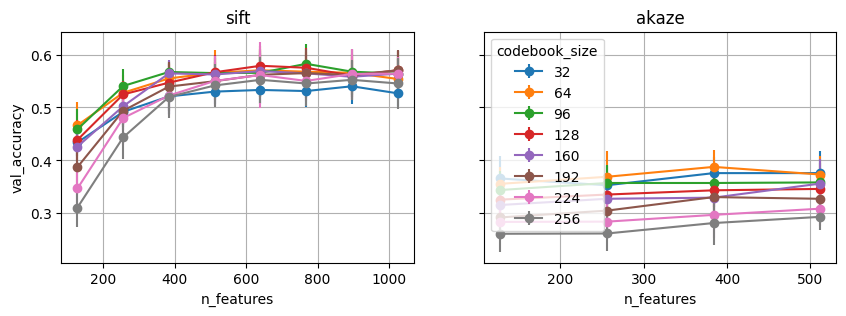

In [52]:
plot_params_comparison(
    df=df,
    detectors=['sift','akaze'],
    xvar='n_features',
    yvar='val_accuracy',
    zvar='codebook_size',
    figsize=(10, 3)
)

AKAZE performed better at a lower codebook size but performed worse than SIFT overall. Therefore, we will focus on SIFT from now on.

Observing the plot, we see that SIFT performed better with a high number of features (800-1000). In these scenario, an intermidiate codebook size performed better (64-192)

From this visualization we can extract that intermidiate values for the codebook size and a high number of features should be used on the definitive DenseSIFT hyperparameter search.

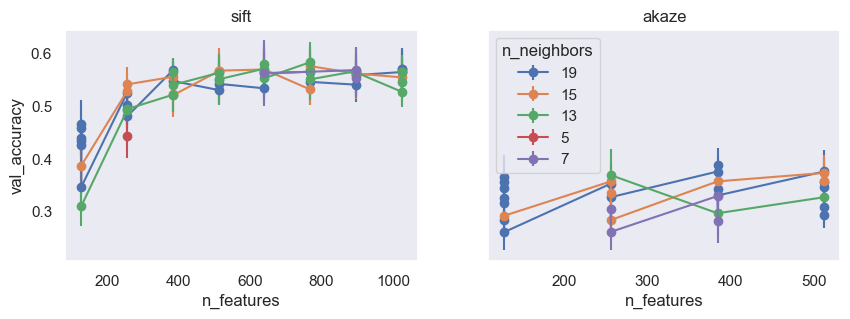

In [58]:
plot_params_comparison(
    df=df,
    detectors=['sift','akaze'],
    xvar='n_features',
    yvar='val_accuracy',
    zvar='n_neighbors',
    figsize=(10, 3)
)

Respect to the number of neighbors of the KNN predictor, we evidenciate that higher values are more interesting, since they assure a more representative poll compared to scenarios with few neighbors

## Dense SIFT's  Grid Search

In [ ]:
params = {
    'detector': ['dense_sift'],
    'n_features': [100, 200, 300],
    'codebook_size': [32, 64, 128],
    'n_neighbors': [9, 13, 15, 17, 10, 21, 23],
    'metric': ["euclidean", "manhattan"],
    'step_size': [10, 100, ],
    'dr_methods': ["pca", "lda"]
}
### Dense SIFT case
for detector in params['detector']:
    if detector == 'dense_sift':
        for n_features in params['n_features']:
            for step_sizes in params['step_size']:

                train_descriptors, filtered_train_labels = compute_descriptors(
                    images=train_images,
                    labels=train_labels,
                    detector=detector,
                    n_features=n_features,
                    step_size = step_sizes,
                    desc='Computing descriptors for TRAIN images...'
                )
                for codebook_size in params['codebook_size']:

                    cbook = generate_codebook(train_descriptors, codebook_size=codebook_size)
                    train_visual_words = compute_visual_words(
                        descriptors=train_descriptors,
                        codebook=cbook
                        codebook_size=codebook_size,
                        desc="Computing visual words vocabulary with TRAIN descriptors..."
                    )

                    clf = KNeighborsClassifier(n_jobs=-1)
                    clf_grid = GridSearchCV(
                        estimator=clf,
                        param_grid={k: params[k] for k in ('n_neighbors', 'metric') if k in params},
                        cv=8,
                        scoring=evaluation_metrics,
                        refit="accuracy",
                        return_train_score=True)
                    clf_grid.fit(train_visual_words, filtered_train_labels)

                    idx_best_accuracy = np.argmin(clf_grid.cv_results_['rank_test_accuracy'])

                    # Params
                    n_neighbors = clf_grid.best_params_['n_neighbors']
                    distance = clf_grid.best_params_['metric']
                    results_data = [detector, n_features, step_sizes, codebook_size, n_neighbors, distance]

                    # Scores
                    for eval_metric in evaluation_metrics:
                        train_score = clf_grid.cv_results_['mean_train_' + eval_metric][idx_best_accuracy]
                        val_score = clf_grid.cv_results_['mean_test_' + eval_metric][idx_best_accuracy]
                        std_train_score = clf_grid.cv_results_['std_train_' + eval_metric][idx_best_accuracy]
                        std_val_score = clf_grid.cv_results_['std_test_' + eval_metric][idx_best_accuracy]
                        results_data.extend([train_score, val_score, std_train_score, std_val_score])

                    results.append(results_data)
                    print(f"Appended GridSearchCV results for {detector} with {n_features} features, {step_sizes} step size and {codebook_size} codebook size.")

columns = ['detector', 'n_features','step_size', 'codebook_size', 'n_neighbors', 'distance'] \

for eval_metric in evaluation_metrics:
    columns.extend([f'train_{eval_metric}', f'val_{eval_metric}', f'std_train_{eval_metric}', f'std_val_{eval_metric}'])

df = pd.DataFrame(results, columns=columns)
os.makedirs(results_folder, exist_ok=True)
df.to_csv(os.path.join(results_folder, filename))
print(f"Saved results to {os.path.join(results_folder, filename)}")

TypeError: compute_visual_words() missing 1 required positional argument: 'codebook'

In [ ]:
data = df.copy()[df['detector'] == 'dense_sift']
sns.barplot(data=data, x="step_size", y="val_accuracy", hue = 'codebook_size', errorbar="sd").set(title='The validation accuracy for dense_sift, based on step size and codebook size')

## Dimensionality reduction with PCA and LDA

We find the cases obtained with GridSearch where the validation score was the highest.

In [12]:
df_copy = df.copy()
df_copy = df_copy.sort_values("val_accuracy", ascending=False)
df_copy = df_copy.drop_duplicates(subset=["detector"], keep="first")
df_copy.drop(columns=df.columns[0], axis=1, inplace=True)
df_copy = df_copy.drop(df_copy.iloc[:, 6:],axis = 1)
best_params = df_copy.values.tolist()

NameError: name 'df' is not defined

In [ ]:
best_params

[['dense_sift', 300, '50', 128, 15, 'manhattan'],
 ['sift', 300, '-', 128, 15, 'euclidean'],
 ['akaze', 300, '-', 32, 15, 'manhattan']]

In [ ]:
train_descriptors, train_labels = compute_descriptors(
                    images=train_images,
                    labels=train_labels,
                    detector='dense_sift',
                    n_features=300,
                    step_size = 50,
                    desc='Computing descriptors for TRAIN images...'
                )
test_descriptors, test_labels = compute_descriptors(
                images=test_images,
                labels=test_labels,
                detector='dense_sift',
                n_features=300,
                step_size = 50,
        desc='Computing descriptors for TEST images...'
            )
cbook = generate_codebook(train_descriptors, 128)
train_visual_words = compute_visual_words(
    descriptors=train_descriptors,
    codebook=cbook,
    codebook_size=128,
    desc="Computing visual words vocabulary with TRAIN descriptors...",
    verbose=True)

test_visual_words = compute_visual_words(
    descriptors=test_descriptors,
    codebook=cbook,
    codebook_size=128,
    desc="Computing visual words vocabulary with Test descriptors...",
    verbose=True)
clf = KNeighborsClassifier(n_neighbors = 15,metric = 'manhattan' ,n_jobs=-1)
clf.fit(train_visual_words, train_labels)
print('\nRegular')
evaluate_vw_predictions(test_visual_words,test_labels, clf)

c:\Users\Guillem\Desktop\MCV-M3-Project\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


NameError: name 'compute_visual_words' is not defined

### Apply dimensionality reduction and compare the results

In [ ]:
def get_dimension_reduction(dim_red_name: str = 'pca', n_components: int = 64) -> Any:
    """
    Creates and parametrize a dimensionality reduction method given a config dictionary
    """
    if dim_red_name == 'pca':
        dim_red = PCA(n_components=n_components)
    elif dim_red_name == 'lda':
        dim_red = LinearDiscriminantAnalysis(n_components=n_components)
    else:
        raise ValueError(
            f"\nGiven dimensionality reduction algorithm {dim_red_name} is an invalid one."
        )
    return dim_red

In [10]:
results = []
evaluation_metrics = ['accuracy', 'f1_weighted']
results_folder = 'results'
filename = 'hyper_params_dim_red.csv'
methods = ['pca', 'lda']

for params in best_params:
    train_descriptors, train_labels = compute_descriptors(
                    images=train_images,
                    labels=train_labels,
                    detector=params[0],
                    n_features=params[1],
                    #step_size = 
                    desc='Computing descriptors for TRAIN images...'
                )
    test_descriptors, test_labels = compute_descriptors(
                    images=test_images,
                    labels=test_labels,
                    detector=params[0],
                    n_features=params[1],
                    #step_size = 
                    desc='Computing descriptors for TEST images...',
                    testing = True
                )
    cbook = generate_codebook(train_descriptors, params[3])
    train_visual_words = compute_visual_words(
        descriptors=train_descriptors,
        codebook=cbook,
        codebook_size=params[3],
        desc="Computing visual words vocabulary with TRAIN descriptors...",
        verbose=True)

    test_visual_words = compute_visual_words(
        descriptors=test_descriptors,
        codebook=cbook,
        codebook_size=params[3],
        desc="Computing visual words vocabulary with Test descriptors...",
        verbose=True)
    clf = KNeighborsClassifier(n_neighbors = params[4],metric = params[5] ,n_jobs=-1)
    clf.fit(train_visual_words, train_labels)
    print('\nRegular')
    reg_res = evaluate_vw_predictions(test_visual_words,test_labels, clf)

    for method in methods:
        if method == 'pca':
            reduced_dims = np.arange(6, 34, 2)
        elif method == 'lda':
            reduced_dims = np.arange(4, len(np.unique(test_labels))) 
        for red_dim in reduced_dims:
            red_clf = KNeighborsClassifier(n_neighbors = params[4],metric = params[5] ,n_jobs=-1)
            dim_red = get_dimension_reduction(dim_red_name=method, n_components=red_dim)
            red_visual_words = dim_red.fit_transform(train_visual_words, train_labels)
            red_clf.fit(red_visual_words, train_labels)
            red_visual_words_test = dim_red.transform(test_visual_words)
            print('\nDim red')
            res = evaluate_vw_predictions(red_visual_words_test,test_labels, red_clf)

            results_data = [params[0], params[1], params[2], params[3], params[4], params[5], method, red_dim, reg_res ,res]

            results.append(results_data)
            print(f" Using {params[0]} with {params[1]} features, {params[2]} step size and {params[3]} codebook size. Appended GridSearch results for {method} with {red_dim} reduced dimension.")

            
columns = ['detector', 'n_features','step_size', 'codebook_size', 'n_neighbors', 'distance', 'method', 'reduced_dimensions', 'regular_accuracy', 'dim_red_accuracy']
df_dr = pd.DataFrame(results, columns=columns)
os.makedirs(results_folder, exist_ok=True)
df_dr.to_csv(os.path.join(results_folder, filename))
print(f"Saved results to {os.path.join(results_folder, filename)}")

NameError: name 'best_params' is not defined

## K-Fold Crossvalidation Pipeline 

### Read and Process Data

In [ ]:
train_images_filenames = pickle.load(open('MIT_split/train_images_filenames.dat',"rb"))
test_images_filenames = pickle.load(open('MIT_split/test_images_filenames.dat',"rb"))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('MIT_split/train_labels.dat',"rb")) 
test_labels = pickle.load(open('MIT_split/test_labels.dat',"rb"))

In [ ]:
train_images_filenames = preprocess_paths(train_images_filenames)
test_images_filenames = preprocess_paths(test_images_filenames)

In [ ]:
train_images = load_images(files=train_images_filenames, desc='Loading TRAIN images...')
test_images = load_images(files=test_images_filenames, desc='Loading TEST images...')

images = np.array(train_images + test_images)
labels = np.array(train_labels + test_labels)

### Configuration

In [ ]:
splits = 10

### Cross-validation loop

In [ ]:


kfold = KFold(n_splits=splits, shuffle=True, random_state=0)
# Iterate over the K-folds
results = []
for train_index, test_index in kfold.split(labels):
    # Split the data into training and test sets
    Y_train, Y_test = labels[train_index], labels[test_index]
    X_train, X_test = images[train_index], images[test_index]

    train_descriptors, train_labels = compute_descriptors(
                    images=train_images,
                    labels=train_labels,
                    detector='dense_sift',
                    n_features=300,
                    step_size = 50
                    desc='Computing descriptors for TRAIN images...'
                )
    test_descriptors, test_labels = compute_descriptors(
                    images=test_images,
                    labels=test_labels,
                    detector='dense_sift',
                    n_features=300,
                    step_size = 50
                    desc='Computing descriptors for TEST images...',
                    testing = True
                )
    cbook = generate_codebook(train_descriptors, 128)
    train_visual_words = compute_visual_words(
        descriptors=train_descriptors,
        codebook=cbook,
        codebook_size=128,
        desc="Computing visual words vocabulary with TRAIN descriptors...",
        verbose=True)

    test_visual_words = compute_visual_words(
        descriptors=test_descriptors,
        codebook=cbook,
        codebook_size=128,
        desc="Computing visual words vocabulary with Test descriptors...",
        verbose=True)
    clf = KNeighborsClassifier(n_neighbors = 15,metric = 'manhattan' ,n_jobs=-1)
    clf.fit(train_visual_words, train_labels)
    print('\nRegular')
    reg_res = evaluate_vw_predictions(test_visual_words,test_labels, clf)
    results.append(reg_res)

print(f'Average: {np.average(results)}')

## Answers and Conclusions

<font color='green'>Test different amounts of local features. What performs best?</font>  
<font color='green'>Use dense SIFT instead of detected keypoints. Conclusions?</font> 

We tried several descriptors including BRISK, KAZE, AKAZE, SIFT and DenseSIFT. Not all of them allowed a wide selection range of features so we we decided to perform a crossvalidated grid search over the last three-
The search and generated plots showcased that DenseSIFT's local features produces better performance. 

<font color='green'>Test different amounts of codebook sizes k. What performs best? </font> 

The codebook size represents the number of words in the vocabulary that is used to represent the visual features of an image. The codebook is then created by clustering the visual features extracted from a set of training images using in our case either SIFT, AKAZE or DENSE_SIFT. The size of the codebook, in our tests, had a major impact in the BOVW model's performance. By increasing the codebook size, we got a better accuracy, but it also meant a longer computational time. We have tested it with values in range …. , and found the optimal values in most cases to be … 


<font color='green'>Test different values of k for the k-nn classifier. What performs best? </font> 

In this case there is again a trade-off between accuracy and computational efficiency that is desired. A larger value helped in increasing the accuracy, as the model considered more information from the nearest neighbours, but it increased the computational cost. Best results were with…


<font color='green'>Test other distances in k-nn classifier. Does that make a difference? Why? </font> 

<font color='green'>Play with reducing dimensionality. Conclusions? </font> 


<font color='green'>Cross-validate everything (topic covered on Wednesday)</font> 

We have added a cross validation part in our project, but the results were mainly based on the cross validation part included in the GridSearch. It helped us tune the hyperparameters and optimised the model performance by evaluating the model on multiple splits of the data.